<a href="https://colab.research.google.com/github/bhavanvir/markov-roulette/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("darkgrid")
np.random.seed(42)

In [92]:
def generate_roulette_data(n_spins=1000):
    """
    Generate synthetic roulette data with timestamps
    Returns both raw outcomes and returns

    Assumptions in the synthetic data:
    1. We assume a perfect American Roulette wheel with equal probability for each pocket (1/38)
    2. We only consider betting on red (not other bet types)
    3. All wins pay 1:1 (ignoring actual casino payout ratios)
    4. We treat 0 and 00 as automatic losses
    """
    red_numbers = {1,3,5,7,9,12,14,16,18,19,21,23,25,27,30,32,34,36}

    numbers = np.random.randint(0, 38, n_spins)  # 0-37 (37 represents 00)

    returns = []
    for num in numbers:
        if num == 0 or num == 37:  # 0 or 00
            returns.append(-1)
        else:
            returns.append(1 if num in red_numbers else -1)

    base_time = datetime(2024, 1, 1)
    timestamps = [base_time + timedelta(minutes=i*3) for i in range(n_spins)]

    return pd.DataFrame({
        'timestamp': timestamps,
        'number': numbers,
        'returns': returns
    })

def create_state_classifications(returns_data, n_states_per_side=3):
    """
    Classify returns into states using quantiles
    """
    states = pd.Series(np.zeros(len(returns_data)), dtype=int)

    negative_mask = returns_data < 0
    positive_mask = returns_data > 0

    negative_indices = np.where(negative_mask)[0]
    positive_indices = np.where(positive_mask)[0]

    if len(negative_indices) > 0:
        neg_splits = np.array_split(negative_indices, n_states_per_side)
        for i, split_indices in enumerate(neg_splits):
            states[split_indices] = i

    if len(positive_indices) > 0:
        pos_splits = np.array_split(positive_indices, n_states_per_side)
        for i, split_indices in enumerate(pos_splits):
            states[split_indices] = i + n_states_per_side
    return states


def calculate_transition_matrix(states):
    """Calculate transition probabilities between states"""
    n_states = len(np.unique(states))
    transitions = np.zeros((n_states, n_states))
    for i, j in zip(states[:-1], states[1:]):
        transitions[i, j] += 1

    row_sums = transitions.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        transition_matrix = np.nan_to_num(transitions / row_sums)
    return transition_matrix


def kelly_criterion(win_prob, odds=1):
    """
    Calculate Kelly Criterion optimal bet size with risk adjustment
    Added safety factor to reduce bet sizes
    """
    kelly = max(0, win_prob - ((1 - win_prob) / odds))
    return kelly


def simulate_portfolio(initial_capital, states, transition_matrix, n_simulations=1000):
    """
    Simulate portfolio value using Kelly Criterion for betting with realistic risk
    """
    states_array = np.array(states, dtype=int)
    portfolio_values = np.zeros((n_simulations, len(states_array)))
    portfolio_values[:, 0] = initial_capital

    n_states = transition_matrix.shape[0]
    mid_state = n_states // 2

    # Track bankruptcies
    bankruptcies = 0

    for sim in range(n_simulations):
        current_capital = initial_capital
        is_bankrupt = False

        for t in range(1, len(states_array)):
            if is_bankrupt:
                portfolio_values[sim, t] = 0
                continue

            current_state = states_array[t-1]

            # Calculate win probability from transition matrix
            win_prob = np.sum(transition_matrix[current_state, mid_state:])

            # Add random noise to win probability to simulate market uncertainty
            win_prob = np.clip(win_prob + np.random.normal(0, 0.05), 0, 1)

            # Calculate Kelly bet size with risk management
            kelly_fraction = kelly_criterion(win_prob)

            # Add minimum bet requirement and maximum bet limit
            min_bet = 10  # Minimum bet size
            max_bet_fraction = 0.25  # Maximum 25% of capital per bet

            if current_capital < min_bet:
                is_bankrupt = True
                bankruptcies += 1
                portfolio_values[sim, t:] = 0
                break

            bet_amount = min(
                max(min_bet, current_capital * kelly_fraction),
                current_capital * max_bet_fraction
            )

            # Apply bet result with realistic odds
            result = 1 if states_array[t] >= mid_state else -1
            current_capital += bet_amount * result

            # Add random transaction costs
            transaction_cost = np.random.uniform(0.001, 0.003) * bet_amount
            current_capital -= transaction_cost

            portfolio_values[sim, t] = max(0, current_capital)

    bankruptcy_rate = bankruptcies / n_simulations
    return portfolio_values, bankruptcy_rate


def analyze_portfolio_performance(portfolio_values):
    """
    Calculate key performance metrics for the portfolio
    """
    final_values = portfolio_values[:, -1]
    mean_final = np.mean(final_values)
    median_final = np.median(final_values)
    std_final = np.std(final_values)

    # Calculate maximum drawdown
    running_max = np.maximum.accumulate(portfolio_values, axis=1)
    drawdowns = (running_max - portfolio_values) / running_max
    max_drawdown = np.max(drawdowns)

    return {
        'mean_final_value': mean_final,
        'median_final_value': median_final,
        'std_final_value': std_final,
        'max_drawdown': max_drawdown,
        'profit_rate': np.mean(final_values > portfolio_values[:, 0]),
        'loss_rate': np.mean(final_values < portfolio_values[:, 0])
    }

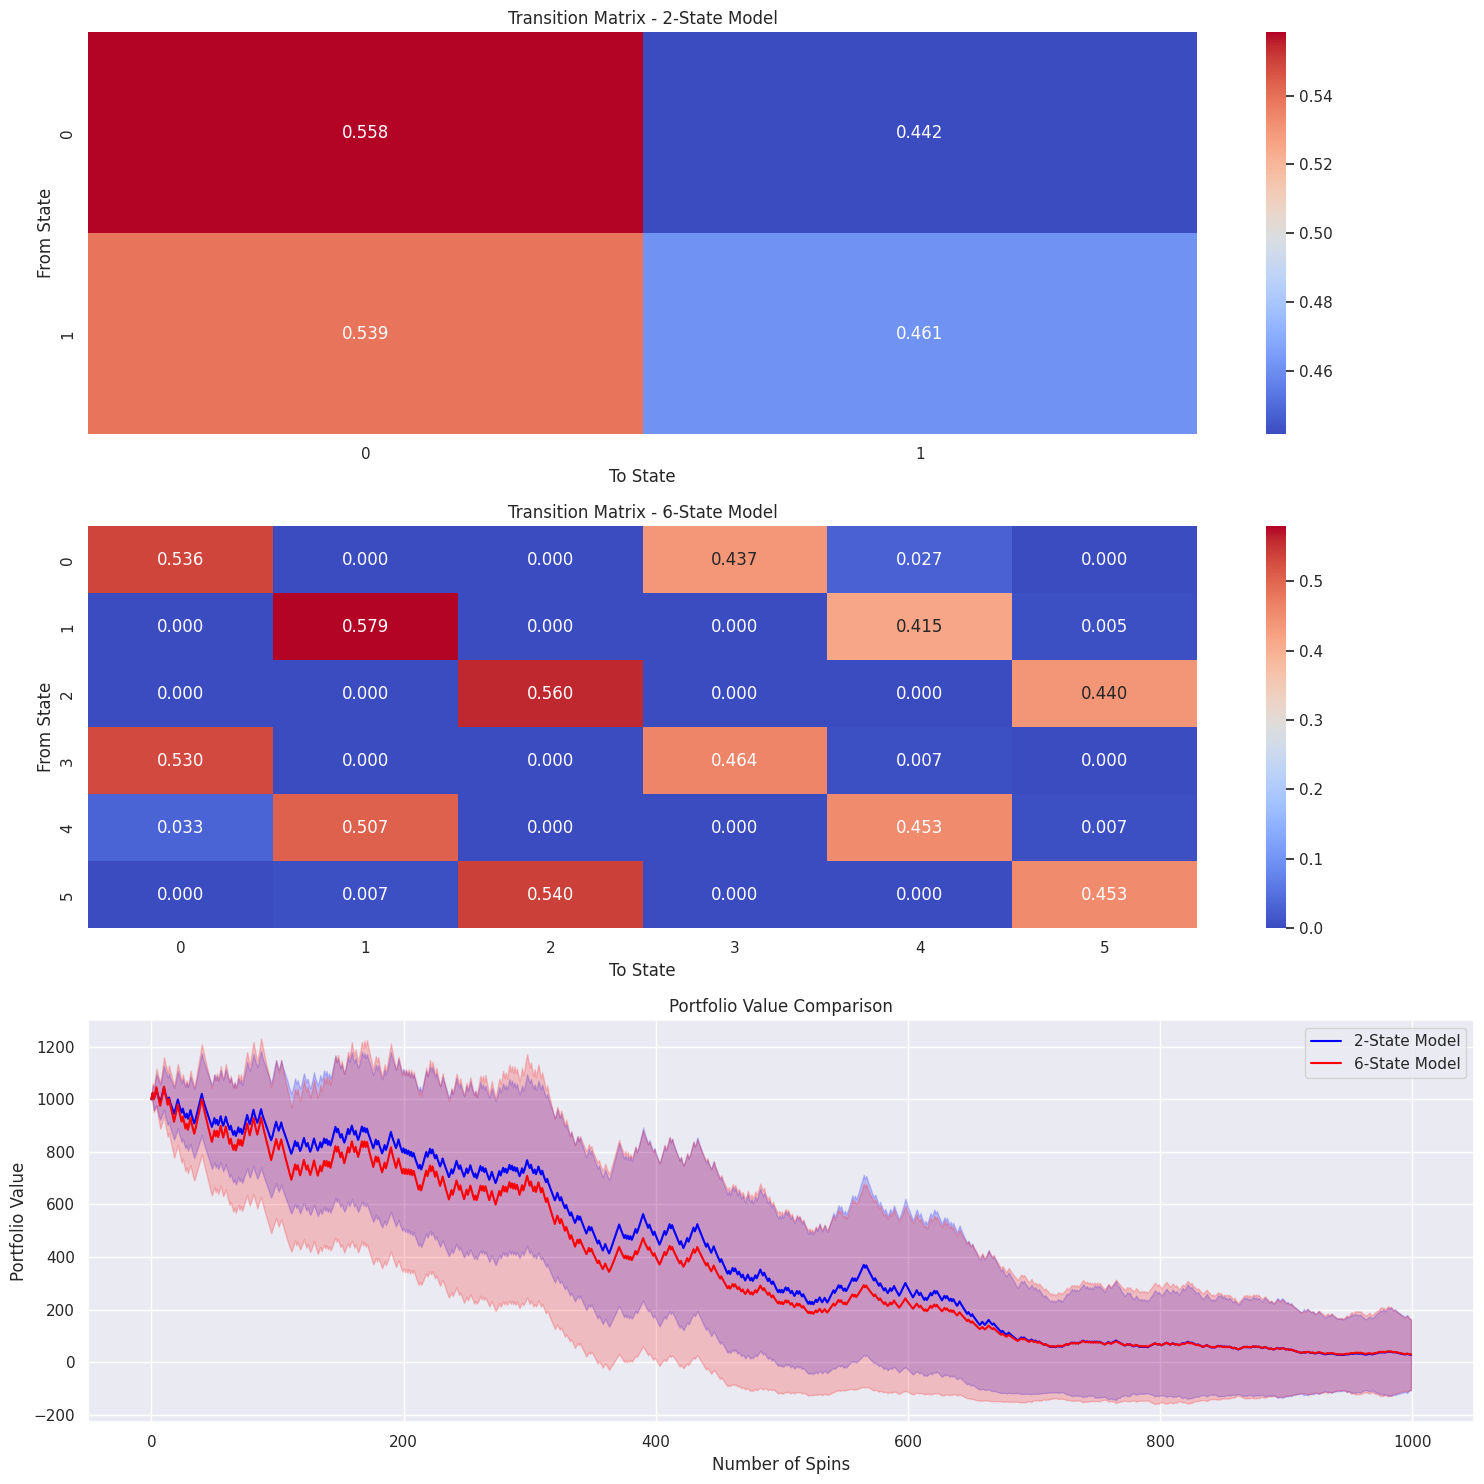


Performance Summary:
2-State Model Final Portfolio (mean): $28.18
6-State Model Final Portfolio (mean): $29.59


In [91]:
# Generate and prepare data
data = generate_roulette_data(1000)
returns = data['returns'].values

# Create state classifications
states_2 = (returns > 0).astype(int)
states_6 = create_state_classifications(returns)

# Calculate transition matrices
transition_matrix_2 = calculate_transition_matrix(states_2)
transition_matrix_6 = calculate_transition_matrix(states_6)

# Simulate portfolios with new risk management
initial_capital = 1000
portfolio_2state, bankruptcy_rate_2 = simulate_portfolio(initial_capital, states_2, transition_matrix_2)
portfolio_6state, bankruptcy_rate_6 = simulate_portfolio(initial_capital, states_6, transition_matrix_6)

# Analyze performance
metrics_2state = analyze_portfolio_performance(portfolio_2state)
metrics_6state = analyze_portfolio_performance(portfolio_6state)

# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Transition Matrix for 2-state model
sns.heatmap(transition_matrix_2, annot=True, cmap='coolwarm', ax=ax1, fmt='.3f')
ax1.set_title('Transition Matrix - 2-State Model')
ax1.set_xlabel('To State')
ax1.set_ylabel('From State')

# Plot 2: Transition Matrix for 6-state model
sns.heatmap(transition_matrix_6, annot=True, cmap='coolwarm', ax=ax2, fmt='.3f')
ax2.set_title('Transition Matrix - 6-State Model')
ax2.set_xlabel('To State')
ax2.set_ylabel('From State')

# Plot 3: Portfolio Value Comparison
mean_2state = np.mean(portfolio_2state, axis=0)
mean_6state = np.mean(portfolio_6state, axis=0)
std_2state = np.std(portfolio_2state, axis=0)
std_6state = np.std(portfolio_6state, axis=0)

ax3.plot(mean_2state, label='2-State Model', color='blue')
ax3.plot(mean_6state, label='6-State Model', color='red')
ax3.fill_between(range(len(mean_2state)),
                 mean_2state - std_2state,
                 mean_2state + std_2state,
                 alpha=0.2, color='blue')
ax3.fill_between(range(len(mean_6state)),
                 mean_6state - std_6state,
                 mean_6state + std_6state,
                 alpha=0.2, color='red')
ax3.set_title('Portfolio Value Comparison')
ax3.set_xlabel('Number of Spins')
ax3.set_ylabel('Portfolio Value')
ax3.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPerformance Summary:")
print(f"2-State Model Final Portfolio (mean): ${mean_2state[-1]:.2f}")
print(f"6-State Model Final Portfolio (mean): ${mean_6state[-1]:.2f}")